In [1]:
import typing
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from autowoe import AutoWoE
from scipy.stats import rankdata
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import KBinsDiscretizer
from tqdm.notebook import tqdm

In [2]:
samples = dict()
for k in ['train', 'oos', 'oot']:
    samples[k] = pd.read_parquet(f'/home/asciishell/s3/jupyter.asciishell.ru/data_{k}.parquet')

In [7]:
features = sorted(set(samples['train'].columns) - {"target", "issue_d", "last_pymnt_d", "last_credit_pull_d"})
cat_features = [
    "emp_title",
    "home_ownership",
    "verification_status",
    "purpose",
    "zip_code",
    "addr_state",
    "initial_list_status",
    "application_type",
    "verification_status_joint",
    "disbursement_method",
]
TARGET = 'target'

In [6]:
samples["train"][[*features, TARGET]]

,addr_state,all_util,annual_inc,annual_inc_joint,application_type,bc_open_to_buy,chargeoff_within_12_mths,collections_12_mths_ex_med,debt_load,desc,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_cu_tl,total_il_high_credit_limit,total_rev_hi_lim,verification_status,verification_status_joint,zip_code,target
0,GA,NaN,50000.0,NaN,Individual,4006.0,0.0,0.0,0.063343,False,...,15000.0,5712.0,5000.0,NaN,0.0,15000.0,Source Verified,__NAN__,307xx,0
1,NJ,NaN,225000.0,NaN,Individual,6990.0,0.0,0.0,0.068472,True,...,645862.0,43188.0,27500.0,NaN,59200.0,42300.0,Source Verified,__NAN__,070xx,0
2,NM,NaN,40000.0,NaN,Individual,13083.0,0.0,0.0,0.094422,False,...,39650.0,23785.0,26800.0,NaN,12000.0,27400.0,Source Verified,__NAN__,875xx,1
3,TX,NaN,130000.0,NaN,Individual,9025.0,0.0,0.0,0.034470,False,...,343624.0,39041.0,19800.0,NaN,44409.0,35800.0,Source Verified,__NAN__,778xx,0
4,TX,NaN,36000.0,NaN,Individual,750.0,0.0,0.0,0.065983,False,...,19844.0,15383.0,9000.0,NaN,9444.0,10400.0,Source Verified,__NAN__,799xx,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787454,TX,NaN,59798.0,NaN,Individual,7362.0,0.0,0.0,0.085813,False,...,192800.0,17938.0,25300.0,NaN,0.0,32800.0,Verified,__NAN__,751xx,0
787455,OH,NaN,92000.0,NaN,Individual,0.0,0.0,0.0,0.072200,False,...,297910.0,34665.0,10000.0,NaN,20610.0,22300.0,Source Verified,__NAN__,441xx,0
787456,CA,NaN,83000.0,NaN,Individual,3544.0,0.0,0.0,0.086352,False,...,542212.0,22723.0,22400.0,NaN,8250.0,33200.0,Source Verified,__NAN__,911xx,0
787457,SC,NaN,96000.0,NaN,Individual,161.0,0.0,0.0,0.058479,False,...,340445.0,52472.0,7000.0,NaN,69394.0,7000.0,Source Verified,__NAN__,293xx,0


In [10]:
auto_woe = AutoWoE(monotonic=True,
                   max_bin_count=5,
                   pearson_th=0.9,
                   vif_th=10.,
                   auc_th=0.52,
                   imp_th=0.001,
                   th_const=32,
                   force_single_split=True,
                   min_bin_size = 0.005,
                   oof_woe=True,
                   n_folds=5,
                   n_jobs=8,
#                    regularized_refit=True,
                   verbose=0)

auto_woe.fit(samples["train"][[*features, TARGET]], 
             target_name=TARGET, 
             validation=samples["oos"][[*features, TARGET]], 
             features_type=dict(zip(features, ['cat' if f in cat_features else 'real' for f in features])))

[LightGBM] [Warning] Starting from the 2.1.2 version, default value for the "boost_from_average" parameter in "binary" objective is true.
This may cause significantly different results comparing to the previous versions of LightGBM.
Try to set boost_from_average=false, if your old models produce bad results
[LightGBM] [Info] Number of positive: 125884, number of negative: 504083
[LightGBM] [Info] Total Bins 13975
[LightGBM] [Info] Number of data: 629967, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199826 -> initscore=-1.387380
[LightGBM] [Info] Start training from score -1.387380


In [13]:
roc_auc_score(samples["oot"]["target"], auto_woe.predict_proba(samples["oot"][features]))

0.6987581251813507

In [104]:
test_target = train_df_1[TARGET]

  0%|          | 0/1000 [00:00<?, ?it/s]

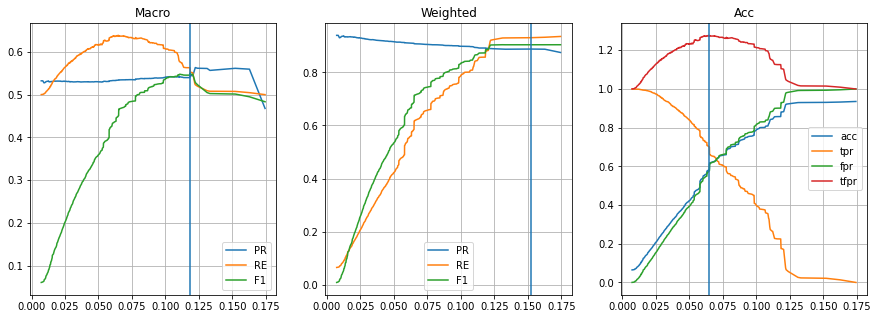

In [105]:
plt.figure(figsize=(15, 5), facecolor='w')

thresholds = []
results = []
proba = auto_woe.predict_proba(train_df_1)
i=0
for x in tqdm(np.percentile(proba, np.arange(0, 100, 0.1))):
    pr, re, f1, _ = precision_recall_fscore_support(test_target, proba > x, average='macro', )
    prw, rew, f1w, _ = precision_recall_fscore_support(test_target, proba > x, average='weighted', )
    tpr = ((proba > x).astype(np.int32) & test_target).sum()  / test_target.sum()
    fpr = ((proba <= x).astype(np.int32) & (~test_target.astype(np.bool_))).sum()   / (~test_target.astype(np.bool_)).sum()
    tfpr = tpr + fpr
    results.append({
        'thr': x,
        'accuracy': accuracy_score(test_target, proba > x),
        'tpr': tpr,
        'fpr': fpr,
        'tfpr': tfpr,
        'precision': pr,
        'recall': re,
        'f1': f1,
        'precision_w': prw,
        'recall_w': rew,
        'f1_w': f1w,
    })
results = pd.DataFrame(results)
plt.subplot(1, 3, i * 3 + 1)
plt.plot(results['thr'], results['precision'], label='PR')
plt.plot(results['thr'], results['recall'], label='RE')
plt.plot(results['thr'], results['f1'], label='F1')
plt.axvline(results.sort_values('f1', ascending=False)['thr'].iloc[0])
plt.grid()
plt.legend()
if i == 0:
    plt.title('Macro')

plt.subplot(1, 3, i * 3 + 2)
plt.plot(results['thr'], results['precision_w'], label='PR')
plt.plot(results['thr'], results['recall_w'], label='RE')
plt.plot(results['thr'], results['f1_w'], label='F1')
plt.axvline(results.sort_values('f1_w', ascending=False)['thr'].iloc[0])
plt.grid()
plt.legend()
if i == 0:
    plt.title('Weighted')
#     plt.ylim([0.8, (results['recall'].max() + plt.gca().get_ylim()[1]) / 2]);

plt.subplot(1, 3, i * 3 + 3)
plt.plot(results['thr'], results['accuracy'], label='acc')
plt.plot(results['thr'], results['tpr'], label='tpr')
plt.plot(results['thr'], results['fpr'], label='fpr')
plt.plot(results['thr'], results['tfpr'], label='tfpr')
plt.axvline(results.sort_values('tfpr', ascending=False)['thr'].iloc[0])
thresholds.append(results.sort_values('tfpr', ascending=False)['thr'].iloc[0])
plt.grid()
plt.legend()
if i == 0:
    plt.title('Acc')
#     plt.ylim([0.925, (results['tfpr'].max() + plt.gca().get_ylim()[1]) / 2])


In [106]:
thresholds[0]

0.06486479779840133

In [109]:
answ_df = test_df[['record_id']].copy()
answ_df['id'] = answ_df['record_id']
answ_df.drop('record_id',axis=1, inplace=True)

answ_df['predict'] = (test_pred >= thresholds[0]).astype(np.int32)

In [110]:
answ_df[['id', 'predict']].to_csv('PD-submit_08.csv',index=False, sep=';')

In [55]:
train_pred = auto_woe.predict_proba(train_df_1)
print("AUC_SCORE TRAIN = {:.5f}".format(roc_auc_score(train_df_1[TARGET], train_pred)))
print("ACCURACY_SCORE TRAIN = {:.5f}".format(accuracy_score(train_df_1[TARGET], train_pred >= np.median(train_pred))))

AUC_SCORE TRAIN = 0.68650
ACCURACY_SCORE TRAIN = 0.53187


In [56]:
test_pred = auto_woe.predict_proba(test_df_1)
np.median(test_pred)

0.07214081300778977

In [14]:
auto_woe.feature_history

{'addr_state': None,
 'all_util': None,
 'annual_inc': None,
 'annual_inc_joint': 'Low importance',
 'application_type': 'Low importance',
 'bc_open_to_buy': 'Pruned by L1 selector',
 'chargeoff_within_12_mths': 'Low importance',
 'collections_12_mths_ex_med': 'Low importance',
 'debt_load': None,
 'desc': 'Low AUC value = 0.51',
 'disbursement_method': 'Low importance',
 'dti': None,
 'dti_joint': 'Low importance',
 'earliest_cr_line': None,
 'emp_length': 'Low AUC value = 0.52',
 'emp_title': 'Low AUC value = 0.52',
 'fico_range_high': None,
 'fico_range_low': 'Low importance',
 'fraq_annual_inc': 'Low importance',
 'funded_amnt': 'High VIF value = 1106.76',
 'funded_amnt_inv': 'Pruned by L1 selector',
 'home_ownership': None,
 'initial_list_status': 'Low AUC value = 0.51',
 'inq_fi': None,
 'installment': 'Pruned by L1 selector',
 'int_rate': None,
 'loan_amnt': 'High VIF value = 201.83',
 'log_annual_inc': 'Low importance',
 'mort_acc': None,
 'num_bc_sats': 'Low AUC value = 0.52',

In [15]:
auto_woe.get_model_represenation()

{'features': {'int_rate': {'f_type': 'real',
   'splits': [9.73, 13.115, 17.785, 23.87],
   'cod_dict': {0: 1.111223,
    1: 0.27234,
    2: -0.274551,
    3: -0.805855,
    4: -1.335388},
   'weight': -0.5917342666555797,
   'nan_value': '__NaN_0__',
   'spec_cod': {'__NaN_0__': 0.0}},
  'term': {'f_type': 'real',
   'splits': [48.0],
   'cod_dict': {0: 0.290089, 1: -0.694667},
   'weight': -0.6933526255948563,
   'nan_value': '__NaN_0__',
   'spec_cod': {'__NaN_0__': 0.0}},
  'fico_range_high': {'f_type': 'real',
   'splits': [671.5, 686.5, 701.5, 736.5],
   'cod_dict': {0: -0.353353,
    1: -0.225733,
    2: -0.034221,
    3: 0.260678,
    4: 0.842539},
   'weight': -0.40784607892608654,
   'nan_value': '__NaN_0__',
   'spec_cod': {'__NaN_0__': 0.0}},
  'debt_load': {'f_type': 'real',
   'splits': [0.028911, 0.047626, 0.078562, 0.101187],
   'cod_dict': {0: 0.551225,
    1: 0.346124,
    2: 0.11813,
    3: -0.111202,
    4: -0.346569},
   'weight': -0.3554385449642782,
   'nan_value

In [16]:
results = []
for k, v in auto_woe.get_model_represenation()['features'].items():
    i = 0
    for i, thr in enumerate(v['splits']):
        row = {'col': k, 'cond':0, 'score': v['cod_dict'][i] * v['weight']}
        if i == 0:
            row['cond'] = 'X <= {}'.format(thr)
        else:
            row['cond'] = '{} < X <= {}'.format(v['splits'][i - 1], thr)
        results.append(row)
    results.append({'col': k, 'cond': 'X > {}'.format(v['splits'][-1]), 'score': v['cod_dict'][i + 1] * v['weight']})
    results.append({'col': k, 'cond': 'NaN', 'score': v['spec_cod'][v['nan_value']] * v['weight']})
results.append({'col': 'intercept', 'cond': '', 'score': auto_woe.get_model_represenation()['intercept']})
pd.DataFrame(results).set_index(['col', 'cond',]).round(3)

KeyError: 'splits'

In [17]:
print(auto_woe.get_sql_inference_query('table'))

SELECT
  1 / (1 + EXP(-(
    -1.389
    -0.592*WOE_TAB.int_rate
    -0.693*WOE_TAB.term
    -0.408*WOE_TAB.fico_range_high
    -0.355*WOE_TAB.debt_load
    -0.418*WOE_TAB.dti
    -0.192*WOE_TAB.verification_status
    -0.142*WOE_TAB.tot_hi_cred_lim
    -0.251*WOE_TAB.mort_acc
    -0.273*WOE_TAB.total_bc_limit
    -0.427*WOE_TAB.num_rev_tl_bal_gt_0
    -0.29*WOE_TAB.annual_inc
    -0.65*WOE_TAB.home_ownership
    -0.074*WOE_TAB.all_util
    -0.423*WOE_TAB.inq_fi
    -0.62*WOE_TAB.total_cu_tl
    -0.229*WOE_TAB.purpose
    -0.798*WOE_TAB.addr_state
    -0.029*WOE_TAB.earliest_cr_line
    -0.248*WOE_TAB.open_acc
  ))) as PROB,
  WOE_TAB.*
FROM 
    (SELECT
    CASE
      WHEN (int_rate IS NULL OR int_rate = 'NaN') THEN 0
      WHEN int_rate <= 9.73 THEN 1.111
      WHEN int_rate <= 13.115 THEN 0.272
      WHEN int_rate <= 17.785 THEN -0.275
      WHEN int_rate <= 23.87 THEN -0.806
      ELSE -1.335
    END AS int_rate,
    CASE
      WHEN (term IS NULL OR term = 'NaN') THEN 0
      WHEN t

In [113]:
answ_df['proba'] = test_pred
answ_df['thr'] = thresholds[0]
answ_df.to_pickle('PD-submit_08.pkl.zip')